## IMPORTS

In [947]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree

from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import  cross_val_score
import warnings

## SETUP

In [948]:
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

sns.set_theme(style='ticks')
sns.set_palette(palette='deep6')

PATH_TRAIN = 'datasets/train.csv'
PATH_TEST = 'datasets/test.csv'

## FUNÇÕES

In [949]:
def obter_colunas_com_nulos(dataframe: pd.DataFrame) -> list:
    return dataframe.columns[dataframe.isnull().any()].tolist()

In [950]:
def get_dataframe(path: str) -> pd.DataFrame:
    dataframe = pd.read_csv(path)
    return dataframe

## EXPLORATORY DATA ANALISYS

### General Info

In [951]:
df1 = get_dataframe(path=PATH_TRAIN)

In [952]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [953]:
df1.select_dtypes(include=['number']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [954]:
df1.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [955]:
df1.columns[df1.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [956]:
cols = df1.columns[df1.isnull().any()]
((df1[cols].isnull().sum() /  df1.shape[0]) * 100).round(2)

LotFrontage    17.74
Alley          93.77
MasVnrType     59.73
MasVnrArea      0.55
BsmtQual        2.53
BsmtCond        2.53
BsmtExposure    2.60
BsmtFinType1    2.53
BsmtFinType2    2.60
Electrical      0.07
FireplaceQu    47.26
GarageType      5.55
GarageYrBlt     5.55
GarageFinish    5.55
GarageQual      5.55
GarageCond      5.55
PoolQC         99.52
Fence          80.75
MiscFeature    96.30
dtype: float64

In [957]:
# df1[df1.select_dtypes(include=['number']).columns].corr()['SalePrice'].sort_values(ascending=False)

### Data Clean

In [958]:
def drop_columns_with_missing_rate_gt(dataframe: pd.DataFrame, missing_values_rate_param: float = 0.3) -> pd.DataFrame:
    removed_cols = []

    for column in dataframe.columns[dataframe.isnull().any()]:
        missing_values_rate = ((dataframe[column].isnull().sum() / dataframe.shape[0]))
        if missing_values_rate > missing_values_rate_param:
            removed_cols.append(column)

    dataframe.drop(columns=removed_cols, inplace=True)
    print(f"the columns {removed_cols} was removed. Missing value rate > {missing_values_rate_param}%")

    return dataframe

In [959]:
def fill_columns_with_median_or_mode(dataframe: pd.DataFrame, missing_values_rate_param: float = 0.1) -> pd.DataFrame:
    
    median_cols = []
    mode_cols = []

    for column in dataframe.columns[dataframe.isnull().any()]:
        missing_values_rate = ((dataframe[column].isnull().sum() / dataframe.shape[0]))
        if missing_values_rate <= missing_values_rate_param:
            if pd.api.types.is_numeric_dtype(dataframe[column]):
                median_cols.append(column)
                median = dataframe[column].median()
                dataframe[column].fillna(median, inplace=True)
            else:
                mode_cols.append(column)
                mode = dataframe[column].mode()[0]
                dataframe[column].fillna(mode, inplace=True)
    
    print("Columns filled with the median values: ", median_cols)
    print("Columns filled with the mode values: ", mode_cols)

    return dataframe

In [960]:
def fill_columns_with_knn(dataframe: pd.DataFrame, missing_values_rate_param: float = 0.1) -> pd.DataFrame:
    
    imputer = KNNImputer()
    knn_columns = []
    df_imputed = dataframe.copy()
    numeric_columns_with_missing = [col for col in dataframe.columns if pd.api.types.is_numeric_dtype(dataframe[col]) and dataframe[col].isnull().any()]
    
    for column in numeric_columns_with_missing:
        missing_values_rate = dataframe[column].isnull().sum() / dataframe.shape[0]
        
        if missing_values_rate > missing_values_rate_param and missing_values_rate <= 0.3:
            knn_columns.append(column)
    
    if knn_columns:
        imputed_values = imputer.fit_transform(dataframe[knn_columns])
        df_imputed[knn_columns] = imputed_values
    
    print('Columns filled with KNN: ', knn_columns)
    
    return df_imputed


In [961]:
def fill_columns_with_unknown(dataframe: pd.DataFrame, columns: list) -> pd.DataFrame:
    for column in columns:
        dataframe[columns].fillna('unknown', inplace=True)
    
    print("Columns filled with with unknown: ", columns)

    return dataframe


### Feature Engineering

In [962]:
def add_is_remod(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['IsRemod'] = dataframe[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 0 if x[0] == x[1] else 1, axis=1)
    print("Adding feature IsRemod")
    return dataframe

In [963]:
def add_age_house_remod(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['AgeHouseOrRemod'] = dataframe[['YearBuilt', 'YearRemodAdd', 'YrSold']].apply(lambda x: x[2] - x[0] if x[0] == x[1] else x[2] - x[1], axis=1)
    print('Adding feature AgeHouseOrRemod')
    return dataframe

In [964]:
def add_bedroom_per_room(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['BedroomPerRoom'] = dataframe['BedroomAbvGr'] / dataframe['TotRmsAbvGrd']
    print('Adding feature BedroomPerRoom')
    return dataframe

In [1010]:
def add_garage_size_per_car(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['GarageSizePerCar'] = dataframe['GarageCars'] / dataframe['GarageArea']
    mean_value = dataframe['GarageSizePerCar'].mean()
    dataframe['GarageSizePerCar'].fillna(mean_value, inplace=True)    
    print('Adding feature GarageSizePerCar')
    return dataframe

In [966]:
def add_garage_age(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['GarageAge'] = dataframe['YrSold'] - dataframe['GarageYrBlt']
    print('Adding feature GarageAge')
    return dataframe

In [967]:
def add_total_porch_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['TotalPorchArea'] = (dataframe['WoodDeckSF'] + dataframe['OpenPorchSF'] + dataframe['EnclosedPorch'] + dataframe['3SsnPorch'] + dataframe['ScreenPorch']) 
    print('Adding feature TotalPorchArea')
    return dataframe

In [968]:
def add_total_porch_area_per_grlivarea(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['TotalPorchAreaPerGrLivArea'] = dataframe['TotalPorchArea'] / dataframe['GrLivArea']
    print('Adding feature TotalPorchAreaPerGrLivArea')
    return dataframe

In [969]:
def add_mean_overall_qual_and_overall_cond(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['MeanOverallQualAndOverallCond'] = (dataframe['OverallQual'] + dataframe['OverallCond']) / 2
    print('Adding feature MeanOverallQualAndOverallCond')
    return dataframe

In [970]:
def add_total_area(dataframe: pd.DataFrame) -> pd.DataFrame:    
    dataframe['TotalArea'] = dataframe['GrLivArea'] + dataframe['TotalBsmtSF']
    print("Adding feature TotalArea")
    return dataframe

In [971]:
# dft = get_dataframe(path=PATH_TRAIN)
# dft = add_is_remod(dataframe=dft)
# dft = add_age_house_remod(dataframe=dft)
# dft = add_bedroom_per_room(dataframe=dft)
# dft = add_garage_size_per_car(dataframe=dft)
# dft = add_garage_age(dataframe=dft)
# dft = add_total_porch_area(dataframe=dft)
# dft = add_total_porch_area_per_grlivarea(dataframe=dft)
# dft = add_mean_overall_qual_and_overall_cond(dataframe=dft)
# dft = add_total_area(dataframe=dft)
# dft

### Hot Encoding and Label Encoding

In [972]:
# dataframe = get_dataframe(path=PATH_TRAIN)

# print("Starting data clean .....")
# dataframe = drop_columns_with_missing_rate_gt(missing_values_rate_param=0.5, dataframe=dataframe)
# dataframe = fill_columns_with_median_or_mode(missing_values_rate_param=0.1, dataframe=dataframe)
# dataframe = fill_columns_with_knn(dataframe=dataframe)
# dataframe = fill_columns_with_unknown(dataframe=dataframe, columns=['FireplaceQu'])
# print("Finish data clean")

# print("Starting feature engeneering ....")
# dataframe = add_is_remod(dataframe=dataframe)
# dataframe = add_age_house_remod(dataframe=dataframe)
# dataframe = add_bedroom_per_room(dataframe=dataframe)
# dataframe = add_garage_size_per_car(dataframe=dataframe)
# dataframe = add_garage_age(dataframe=dataframe)
# dataframe = add_total_porch_area(dataframe=dataframe)
# dataframe = add_total_porch_area_per_grlivarea(dataframe=dataframe)
# dataframe = add_mean_overall_qual_and_overall_cond(dataframe=dataframe)
# dataframe = add_total_area(dataframe=dataframe)
# print("Finish feature engeneering ....")

In [973]:
numeric_cols = dataframe.select_dtypes(include=['number']).columns

In [974]:
numeric_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'IsRemod',
       'AgeHouseOrRemod', 'BedroomPerRoom', 'GarageSizePerCar', 'GarageAge',
       'TotalPorchArea', 'TotalPorchAreaPerGrLivArea',
       'MeanOverallQualAndOverallCond', 'TotalArea'],
      dtype='object')

In [975]:
dataframe['OverallQual']

0       7
1       6
2       7
3       7
4       8
       ..
1455    6
1456    6
1457    7
1458    5
1459    5
Name: OverallQual, Length: 1460, dtype: int64

### OverallQual, GrLivArea, GarageCars, TotalBsmtSF e influências em SalePrice

In [976]:
df1.loc[:, ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'SalePrice']]

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,SalePrice
0,7,1710,2,856,208500
1,6,1262,2,1262,181500
2,7,1786,2,920,223500
3,7,1717,3,756,140000
4,8,2198,3,1145,250000
...,...,...,...,...,...
1455,6,1647,2,953,175000
1456,6,2073,2,1542,210000
1457,7,2340,1,1152,266500
1458,5,1078,1,1078,142125


In [977]:
def plot_bloxplots(dataset: pd.DataFrame, columns: list = [], target: str = 'SalePrice'):
    
    cols = columns if columns else dataset.select_dtypes(include=['number']).columns
    
    for column in cols:
        if column != target:
            plt.figure(figsize=(10, 6))  
            sns.boxplot(data=dataset, x=column, y=target)
            sns.despine(offset=10, trim=True)
            plt.title(f'Boxplot of {column} vs {target}')  
            plt.show()  

In [978]:
def plot_scatterplot(dataset: pd.DataFrame, columns: list = [], target: str = 'SalePrice', hue_param: str = 'OverallQual'):
        
    cols = columns if columns else dataset.select_dtypes(include=['number']).columns
    
    for column in cols:
        if column != target:
            plt.figure(figsize=(10, 6))  
            sns.relplot(data=dataset, x=column, y=target, hue=hue_param)
            sns.despine(offset=10, trim=True)
            plt.title(f'Scatterplot of {column} vs {target}')  
            plt.show()  

In [979]:
def obter_stats(dataset: pd.DataFrame, columns: list, target: str = 'SalePrice'):

    X = dataset[columns]
    y = dataset[target]
    X = sm.add_constant(X)  

   
    model = sm.OLS(y, X).fit()

    print(model.summary())

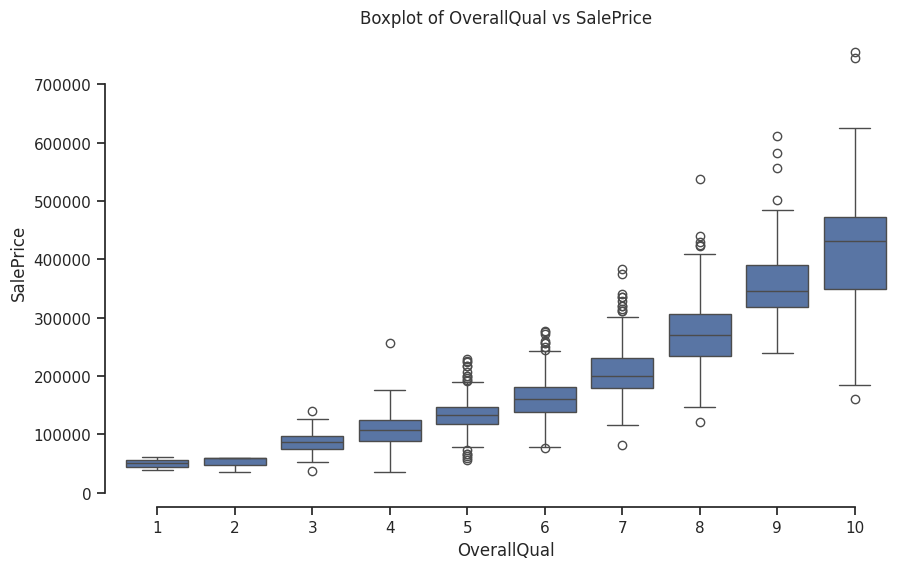

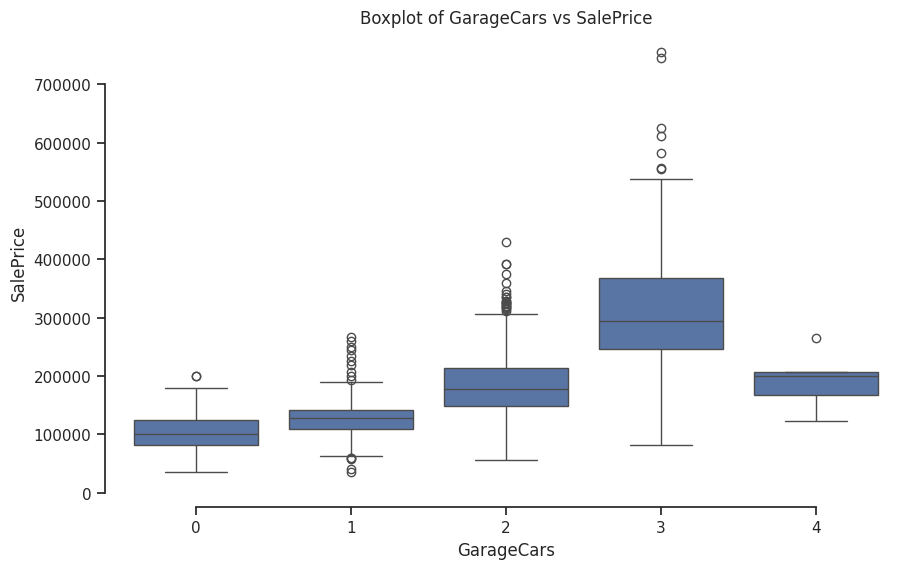

In [980]:
plot_bloxplots(dataset=df1, columns=['OverallQual', 'GarageCars'])

<Figure size 1000x600 with 0 Axes>

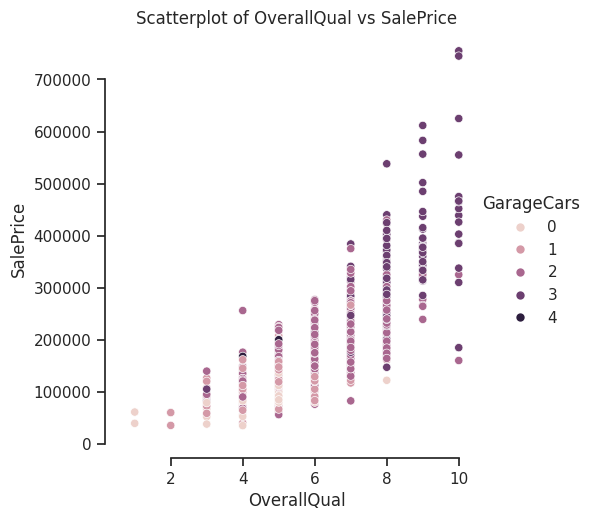

<Figure size 1000x600 with 0 Axes>

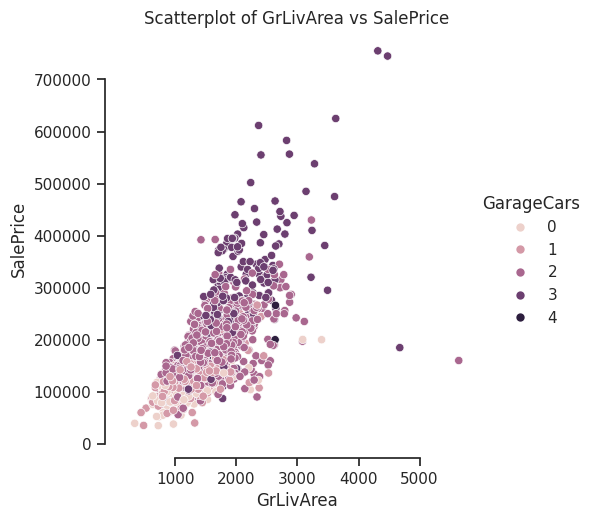

<Figure size 1000x600 with 0 Axes>

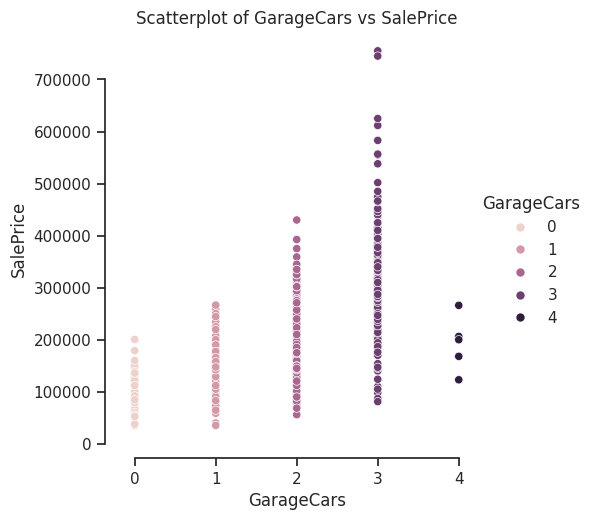

<Figure size 1000x600 with 0 Axes>

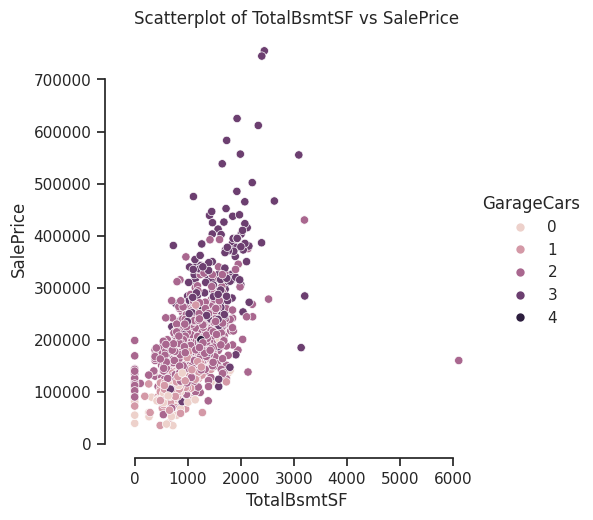

In [981]:
plot_scatterplot(dataset=df1, hue_param='GarageCars', columns=['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'SalePrice'])

In [982]:
df1['AreaTotal'] = df1[['GrLivArea', 'TotalBsmtSF']].apply(lambda x: (x[0] + x[1]),  axis=1)
df1[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'SalePrice']].corr()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,SalePrice
OverallQual,1.00,0.59,0.60,0.54,0.79
GrLivArea,0.59,1.00,0.47,0.45,0.71
GarageCars,0.60,0.47,1.00,0.43,0.64
TotalBsmtSF,0.54,0.45,0.43,1.00,0.61
SalePrice,0.79,0.71,0.64,0.61,1.00


In [983]:
obter_stats(dataset=df1, columns=['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'AreaTotal'])

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1156.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:14:37   Log-Likelihood:                -17500.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1455   BIC:                         3.504e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.925e+04   4639.866    -21.390      

## TREINANDO E AVALIANDO MODELOS

In [984]:
from sklearn.preprocessing import MinMaxScaler

In [985]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, SGDRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

estimators = [
    LinearRegression(),
    Ridge(alpha=0.5),
    Lasso(alpha=0.1),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    BayesianRidge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    KNeighborsRegressor(),
    HuberRegressor(),
    PassiveAggressiveRegressor(max_iter=1000, tol=1e-3),
    SGDRegressor(max_iter=1000, tol=1e-3),
    TheilSenRegressor(),
    RANSACRegressor(),
    LGBMRegressor(verbose=-1),
    XGBRegressor()
]

In [986]:
x_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
target = ['SalePrice']
x_cols_e_target = x_cols + target

min_max_scaler_fields = ['TotalBsmtSF', 'GrLivArea', 'TotalArea', 'OverallQual', 'GarageCars', 'GarageArea']
one_hot_encoder_fields = []

In [987]:
def display_stats(d: dict):
    dataframe = pd.DataFrame.from_dict(d)
    dataframe.sort_values(by=['score', 'std'], ascending=[True, True], inplace=True)
    print(dataframe)

In [988]:
def obter_conj_treinamento_e_teste_estratificado_por(dataframe: pd.DataFrame, categoria: str):
    # Convertendo a variável contínua em categorias
    dataframe['categoria_stratificada'] = pd.qcut(dataframe[categoria], q=10, labels=False)
    
    strat_train_set = None
    strat_valid_set = None

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, valid_index in split.split(dataframe, dataframe['categoria_stratificada']):
        strat_train_set = dataframe.loc[train_index]
        strat_valid_set = dataframe.loc[valid_index]

    X_train = strat_train_set.drop(columns=[categoria, 'categoria_stratificada'])
    y_train = strat_train_set[categoria]
    X_val = strat_valid_set.drop(columns=[categoria, 'categoria_stratificada'])
    y_val = strat_valid_set[categoria]
    
    return X_train, X_val, y_train, y_val

In [989]:
def get_train_test_split(dataframe: pd.DataFrame):
    X = dataframe
    y = dataframe['SalePrice']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [990]:
def update_cols_and_target():
    global x_cols_e_target
    x_cols_e_target = x_cols + target

In [991]:
def add_or_remove_field_to_process(campo: str, operacao: str = 'add'):
    if operacao == 'add':
        if campo not in x_cols: 
            x_cols.append(campo)    
    elif campo in x_cols: 
        x_cols.remove(campo)
    
    update_cols_and_target()

In [992]:
def process_min_max_scaler(dataframe: pd.DataFrame) -> pd.DataFrame:
    for col in min_max_scaler_fields:
        dataframe[col] = MinMaxScaler().fit_transform(dataframe[[col]])
    return dataframe

In [1012]:
def process_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    print("Starting data clean .....")
    dataframe = drop_columns_with_missing_rate_gt(missing_values_rate_param=0.3, dataframe=dataframe)
    dataframe = fill_columns_with_median_or_mode(missing_values_rate_param=0.1, dataframe=dataframe)
    dataframe = fill_columns_with_knn(dataframe=dataframe)
    # dataframe = fill_columns_with_unknown(dataframe=dataframe, columns=['FireplaceQu'])
    print("Finish data clean")

    print("Starting feature engeneering ....")
    dataframe = add_is_remod(dataframe=dataframe)
    dataframe = add_age_house_remod(dataframe=dataframe)
    dataframe = add_bedroom_per_room(dataframe=dataframe)
    dataframe = add_garage_size_per_car(dataframe=dataframe)
    dataframe = add_garage_age(dataframe=dataframe)
    dataframe = add_total_porch_area(dataframe=dataframe)
    dataframe = add_total_porch_area_per_grlivarea(dataframe=dataframe)
    dataframe = add_mean_overall_qual_and_overall_cond(dataframe=dataframe)
    dataframe = add_total_area(dataframe=dataframe)
    print("Finish feature engeneering ....")

    has_nulls = dataframe.columns[dataframe.isnull().any()].tolist()
    
    if has_nulls:
        print(f"########## O DATAFRAME POSSUI AS SEGUINTES COLUNAS NULAS: {has_nulls} ##########")


    return dataframe

In [994]:
def cross_val_estimators(X, y):
    
    d = {'models': [], 'score': [], 'std': []}

    rmse_scorer = make_scorer(root_mean_squared_error)

    for estimator in estimators:
        scores = cross_val_score(estimator=estimator, X=X, y=y, cv=10, scoring=rmse_scorer)
        
        d['models'].append(type(estimator).__name__)
        d['score'].append(scores.mean())
        d['std'].append(scores.std())


    display_stats(d)

In [1013]:
train_set = get_dataframe(path=PATH_TRAIN)

# X_train, X_val, y_train, y_val = get_train_test_split(train_set)

# X_train_processed = process_dataframe(X_train)
# X_valid_processed = process_dataframe(X_val)


X_train, X_val, y_train, y_val = obter_conj_treinamento_e_teste_estratificado_por(dataframe=train_set, categoria='SalePrice')
X_train_processed = train_processed_datafram = process_dataframe(X_train)
valid_processed_dataframe = process_dataframe(X_val)

Starting data clean .....
the columns ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] was removed. Missing value rate > 0.3%
Columns filled with the median values:  ['MasVnrArea', 'GarageYrBlt']
Columns filled with the mode values:  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Columns filled with KNN:  ['LotFrontage']
Finish data clean
Starting feature engeneering ....
Adding feature IsRemod
Adding feature AgeHouseOrRemod
Adding feature BedroomPerRoom
Adding feature GarageSizePerCar
Adding feature GarageAge
Adding feature TotalPorchArea
Adding feature TotalPorchAreaPerGrLivArea
Adding feature MeanOverallQualAndOverallCond
Adding feature TotalArea
Finish feature engeneering ....
Id column was dropedd ...
Starting data clean .....
the columns ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] was removed. Missing value rate > 0.3%
Columns fill

In [1014]:
numeric_cols = X_train.select_dtypes(include=['number']).columns
numeric_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [1016]:
train_to_crossval = process_dataframe(get_dataframe(path=PATH_TRAIN))
numeric_cols_crossval = train_to_crossval.select_dtypes(include=['number']).columns
cross_val_estimators(X=train_to_crossval[numeric_cols_crossval], y=train_to_crossval['SalePrice'])

Starting data clean .....
the columns ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] was removed. Missing value rate > 0.3%
Columns filled with the median values:  ['MasVnrArea', 'GarageYrBlt']
Columns filled with the mode values:  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Columns filled with KNN:  ['LotFrontage']
Finish data clean
Starting feature engeneering ....
Adding feature IsRemod
Adding feature AgeHouseOrRemod
Adding feature BedroomPerRoom
Adding feature GarageSizePerCar
Adding feature GarageAge
Adding feature TotalPorchArea
Adding feature TotalPorchAreaPerGrLivArea
Adding feature MeanOverallQualAndOverallCond
Adding feature TotalArea
Finish feature engeneering ....
Id column was dropedd ...
                        models                   score                     std
16             RANSACRegressor                    0.00                    0.00
0   

                        models                score                  std
8    GradientBoostingRegressor             28677.42              7201.29
17               LGBMRegressor             30804.10              6653.78
7          ExtraTreesRegressor             31220.85              9527.02
6        RandomForestRegressor             31419.85              7631.44
18                XGBRegressor             31550.14              8302.59
9            AdaBoostRegressor             35346.72              5157.17
3                   ElasticNet             37431.44             14461.37
1                        Ridge             37508.68             14091.63
2                        Lasso             37512.19             14086.11
0             LinearRegression             37512.24             14085.96
15           TheilSenRegressor             37634.86             15745.50
16             RANSACRegressor             41389.72             12236.83
5        DecisionTreeRegressor             42249.67             10415.07
4                BayesianRidge             42536.29             14699.95
12              HuberRegressor             44120.52             14087.84
11         KNeighborsRegressor             46040.14              8888.58
13  PassiveAggressiveRegressor             51968.28             18625.28
10                         SVR             80157.75             13432.12
14                SGDRegressor 80946829393466784.00 35596776848790012.00

## SUBIMIT

In [1034]:
train_set = get_dataframe(path=PATH_TRAIN)
train_processed = process_dataframe(train_set)
numeric_cols = train_processed.select_dtypes(include=['number']).columns

X_train = train_processed[numeric_cols]
X_train.drop(columns="SalePrice", inplace=True)
y_train = train_processed['SalePrice']

estimator = GradientBoostingRegressor()
estimator.fit(X=X_train, y=y_train)

Starting data clean .....
the columns ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] was removed. Missing value rate > 0.3%
Columns filled with the median values:  ['MasVnrArea', 'GarageYrBlt']
Columns filled with the mode values:  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Columns filled with KNN:  ['LotFrontage']
Finish data clean
Starting feature engeneering ....
Adding feature IsRemod
Adding feature AgeHouseOrRemod
Adding feature BedroomPerRoom
Adding feature GarageSizePerCar
Adding feature GarageAge
Adding feature TotalPorchArea
Adding feature TotalPorchAreaPerGrLivArea
Adding feature MeanOverallQualAndOverallCond
Adding feature TotalArea
Finish feature engeneering ....
Id column was dropedd ...


GradientBoostingRegressor()

In [ ]:
test_to_predict = process_dataframe(get_dataframe(path=PATH_TEST))
numeric_cols_to_test = test_to_predict.select_dtypes(include=['number']).columns

pred = estimator.predict(test_to_predict[numeric_cols_to_test])

# d = {'Id': test_to_predict['Id'], 'SalePrice': pred}
# subimit = pd.DataFrame.from_dict(d)
# submit


In [1039]:
pred

array([128397.77569405, 165779.55280739, 179289.89875713, ...,
       179389.07009973, 127236.3929526 , 235922.19023426])